In [223]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import glob
from PlanRecognition import find_colors
import itertools
%matplotlib inline

# PLANS

In [2]:
def permutations(array, n=None, perm=[]):
    if n == None:
        n = len(array)
    if n == 0:
        yield perm
    else:
        for i in range(len(array)):
            yield from permutations(array[:i] + array[i + 1:], n - 1,
                                    perm + [array[i]])
def all_plans():
    yield from permutations(list(range(5)), 3)


PLANS = list(all_plans())
COLORS = np.array([[0, 124, 176], [208, 93, 40], [14, 14, 16], [97, 153, 59],
          [247, 181, 0]], dtype=np.uint8)
LABELS = ['blue', 'orange', 'black', 'green', 'yellow']

# Original colors

[[[ 99 255 176]
  [  9 206 208]
  [120  32  16]
  [ 48 157 153]
  [ 22 255 247]]]


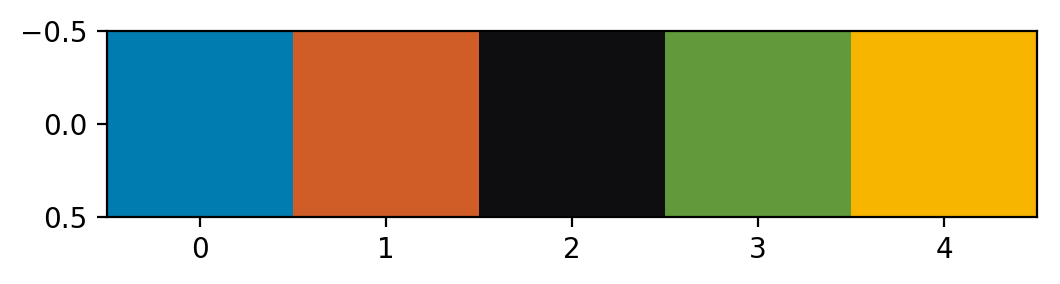

In [3]:
orig_colors_img = np.array([COLORS])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(orig_colors_img)
print(cv2.cvtColor(orig_colors_img, cv2.COLOR_RGB2HSV))

# Show image

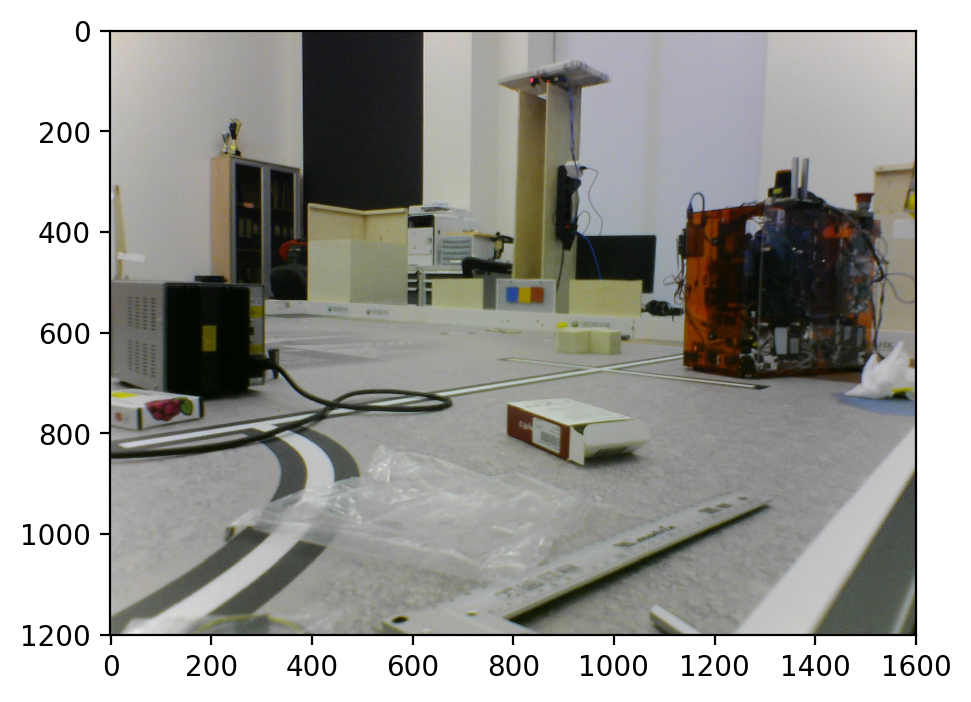

In [5]:
img = cv2.cvtColor(cv2.imread("imgs/041_3.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(img);

# Projection transformation using specific matrix

In [35]:
step = 6

In [36]:
img_points = np.float32([(798, 549), (798, 488), (912, 487), (912, 553)])
h_border = 3 * step * 2
w_border = 7 * step * 2
h_rect = int(130 / 30 * step)
w_rect = int(300 / 30 * step)
dw = (w_border - w_rect) / 2
dh = (h_border - h_rect) / 2
real_points = np.float32([(dw, h_border - dh), (dw, dh), 
                          (w_border - dw, dh), (w_border - dw, h_border - dh)])
M = cv2.getPerspectiveTransform(img_points, real_points)

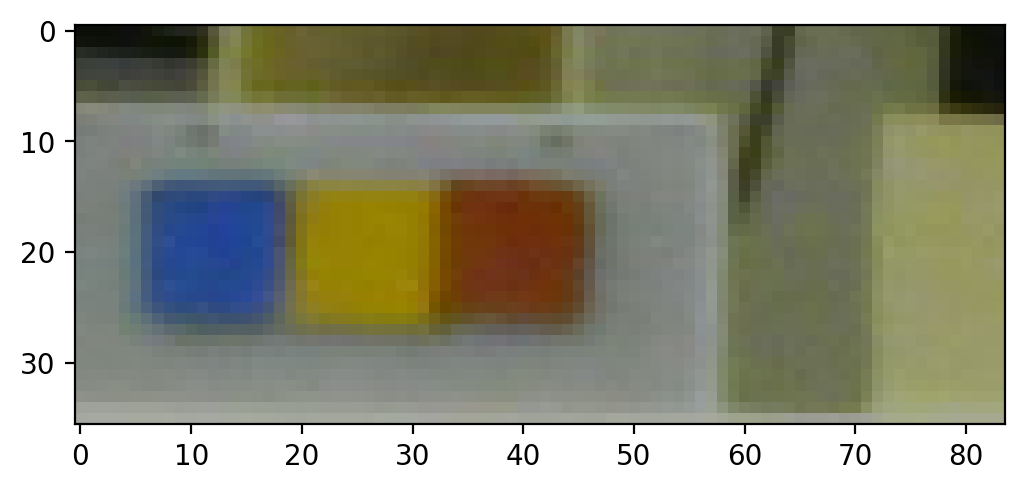

In [37]:
small_img = cv2.warpPerspective(img, M, (w_border, h_border))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(small_img);

# Image equalization

## Histogram

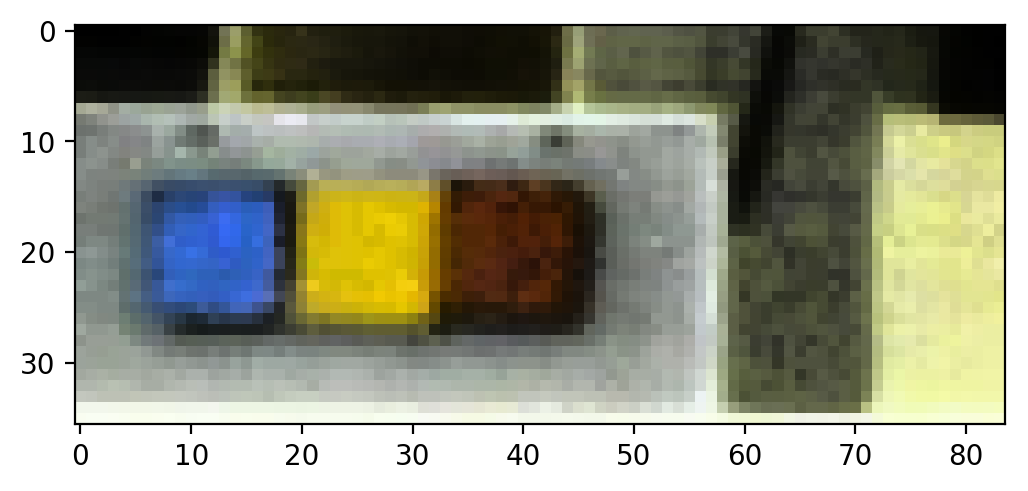

In [38]:
# hist_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2YCrCb)
hist_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2HSV)
hist_img[:, :, 2] = cv2.equalizeHist(hist_img[:, :, 2])
hist_img = cv2.cvtColor(hist_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(hist_img);

## Clahe + median

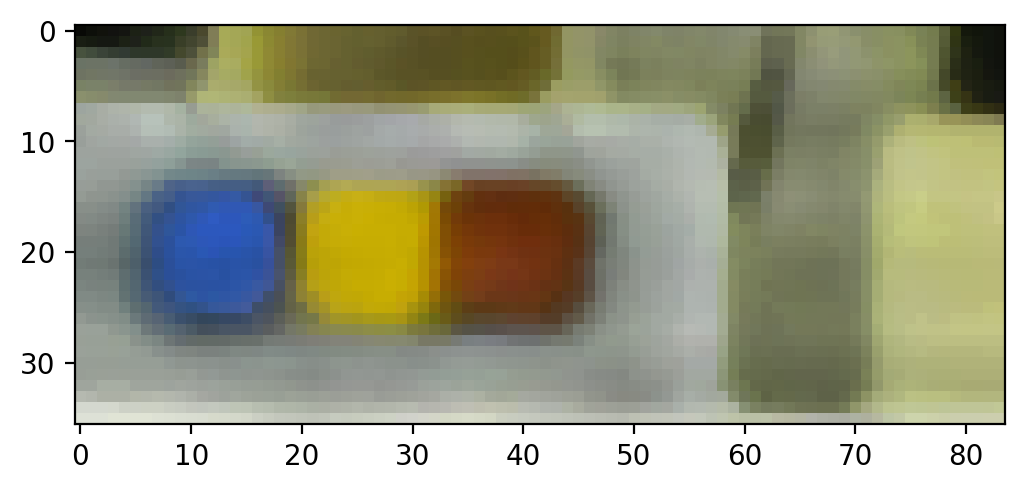

In [146]:
vl = int(step / 4)
img_1 = cv2.medianBlur(small_img, step - 1 + step % 2)
clh_img = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img[:, :, 2] = clahe.apply(clh_img[:, :, 2])
clh_img = cv2.cvtColor(clh_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_img);

## Laplacian + CLh + median

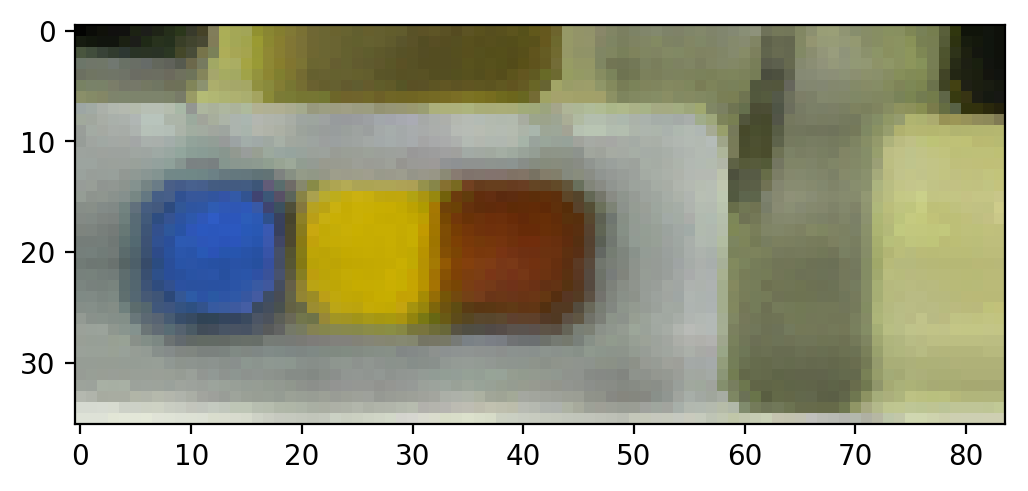

In [134]:
#img_1 = cv2.GaussianBlur(small_img,(13,13),10)
vl = int(step)
img_1 = cv2.medianBlur(small_img, vl - 1 + vl % 2)

clh_img_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img_1[:, :, 2] = clahe.apply(clh_img_1[:, :, 2])
clh_img_1 = cv2.cvtColor(clh_img_1, cv2.COLOR_HSV2RGB)

img_1 = clh_img_1
c = -0.10
img_1 = c * cv2.Laplacian(img_1 / 255, cv2.CV_64F) + img_1 / 255
img_1 = (255 * img_1.clip(0, 1)).astype(np.uint8)
clh_img_1 = img_1

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_img_1);

# Rough image

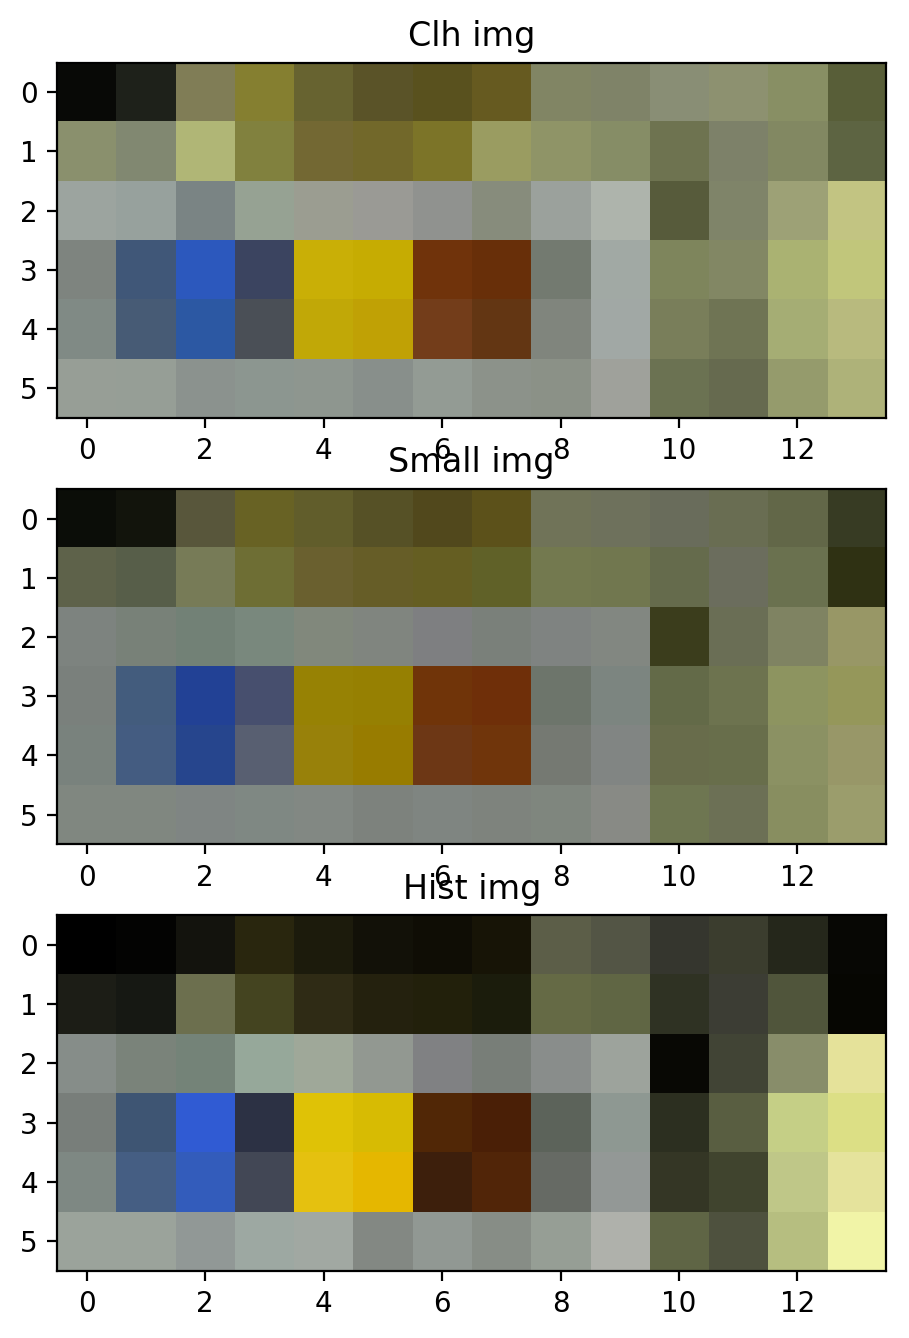

In [136]:
points1 = np.float32([(0, h_border), (0, 0), 
                       (w_border, 0)])
points2 = np.float32([(0, h_border // step), (0, 0), 
                       (w_border // step, 0)])

rough_img_1 = cv2.warpAffine(clh_img, cv2.getAffineTransform(points1, points2), 
                    (w_border // step, h_border // step))

rough_img_2 = cv2.warpAffine(small_img, cv2.getAffineTransform(points1, points2), 
                    (w_border // step, h_border // step))
rough_img_3 = cv2.warpAffine(hist_img, cv2.getAffineTransform(points1, points2), 
                    (w_border // step, h_border // step))
fig, ax = plt.subplots(3, 1, figsize=(6, 8), dpi=200)
ax[0].set_title("Clh img")
ax[0].imshow(rough_img_1)
ax[1].set_title("Small img")
ax[1].imshow(rough_img_2)
ax[2].set_title("Hist img")
ax[2].imshow(rough_img_3)

In [41]:
rough_img = rough_img_1

# Cube sequence searching

In [375]:
from colormath.color_diff import delta_e_cie2000, delta_e_cmc 
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
import skimage.color

def color_distance(c1, c2):
    color1 = sRGBColor(*c1, is_upscaled=True)
    lab_color1 = convert_color(color1, LabColor)
    color2 = sRGBColor(*c2, is_upscaled=True)
    lab_color2 = convert_color(color2, LabColor)
    return delta_e_cmc(lab_color1, lab_color2)

In [359]:
def get_distances_colormath(input_img):
    hight, width = input_img.shape[0:2]
    dist_array = np.zeros((hight, width, COLORS.shape[0]))
    for i in range(COLORS.shape[0]):
        dist_array[:, :, i] = np.apply_along_axis(color_distance, 2, input_img, COLORS[i])
    return dist_array

In [419]:
def get_distances_skimage(input_img):
    lab_COLORS = skimage.color.rgb2lab(COLORS[np.newaxis, :, :])[0]
    lab_img = skimage.color.rgb2lab(input_img)
    dist_array = skimage.color.deltaE_cmc(lab_img[:, :, np.newaxis], lab_COLORS[np.newaxis, np.newaxis, :],
                                          2, 1)
    return dist_array

In [348]:
def get_distances(input_img):
    hight, width = input_img.shape[0:2]
    LAB_COLORS = cv2.cvtColor(COLORS[np.newaxis, :, :], cv2.COLOR_RGB2Lab)[0].astype(np.int32)
    lab_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2Lab)
    dist_array = np.zeros((hight, width, COLORS.shape[0]))
    for i in range(COLORS.shape[0]):
        dist_array[:, :, i] = np.sum((LAB_COLORS[i] -lab_img) ** 2 * k_metric[:, 0], axis=2) ** 0.5
    return dist_array

## Dist array for full image

In [420]:
%%time
input_img = clh_img
full_dist_array = get_distances_skimage(clh_img)
hight, width = input_img.shape[0] // step, input_img.shape[1] // step
dist_array = np.zeros((hight, width, COLORS.shape[0]))
for i in range(hight):
    for j in range(width):
        img_ = full_dist_array[step*i:step*i+step, step*j:step*j+step, :]
        dist_array[i, j, :] = np.mean(np.mean(img_,axis=0), axis=0)

CPU times: user 6.67 ms, sys: 0 ns, total: 6.67 ms
Wall time: 6.69 ms


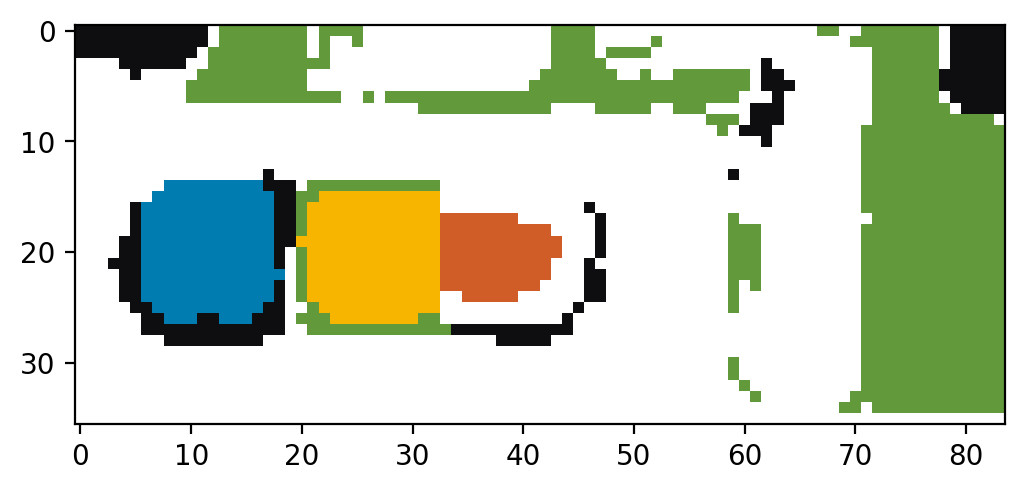

In [421]:
min_inds = np.argmin(full_dist_array, axis=2)
min_values = np.min(full_dist_array, axis=2)
min_min = np.mean(min_values)
out_img = COLORS[min_inds]
out_img[min_values > min_min] = [255, 255, 255]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(out_img);

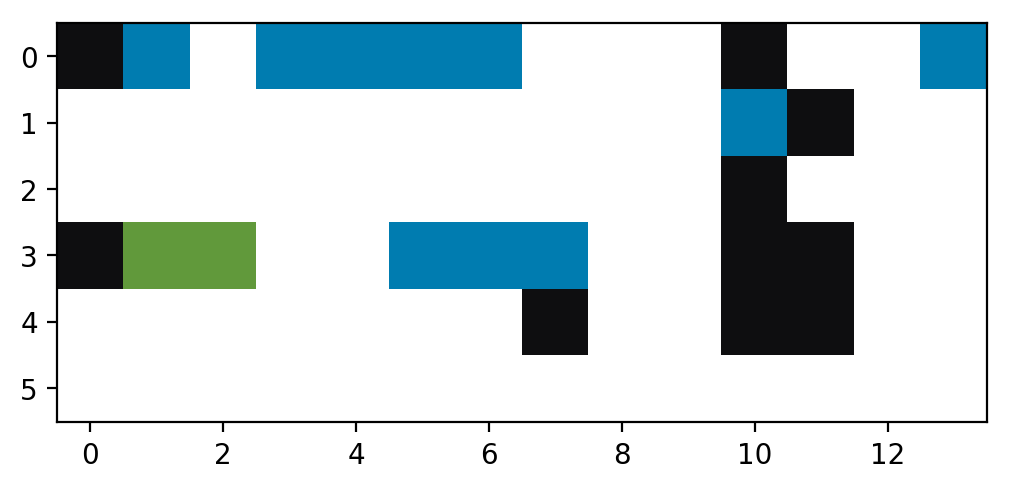

In [418]:
min_inds = np.argmin(dist_array, axis=2)
min_values = np.min(dist_array, axis=2)
min_min = np.mean(min_values)
out_img = COLORS[min_inds]
out_img[min_values > min_min] = [255, 255, 255]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(out_img);

## Dist array for rough image

In [139]:
hight, width = rough_img.shape[0:2]
dist_array = np.zeros((hight, width, COLORS.shape[0]))

for i in range(COLORS.shape[0]):
    dist_array[:, :, i] = np.apply_along_axis(color_distance, 2, rough_img, COLORS[i])

## Search plan

In [422]:
plan_dist_array = np.zeros((hight, width - 4, len(PLANS)))

for i, plan in enumerate(PLANS):
    plan_dist_array[:, :, i] = sum([np.roll(dist_array[:, :, plan[x]]**2, -2 * x, axis=1)[:, :-4] for x in range(3)])

best_plan = np.unravel_index(np.argmin(plan_dist_array), (hight, width - 4, len(PLANS)))[2]
ind = np.unravel_index(np.argmin(plan_dist_array), (hight, width - 4, len(PLANS)))[0:2]

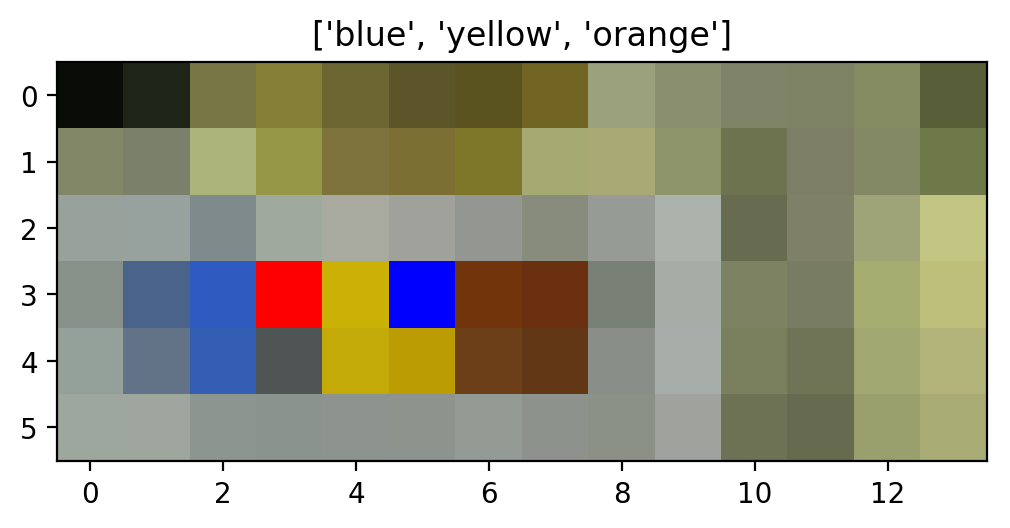

In [423]:
out_img = rough_img.copy()
out_img[ind[0], ind[1] + 1] = np.array([255, 0, 0])
out_img[ind[0], ind[1] + 3] = np.array([0, 0, 255])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.set_title([LABELS[PLANS[best_plan][x]] for x in range(3)])
ax.imshow(out_img);

# Projection transformation on images

In [16]:
files = glob.glob("imgs/*.png")
plans = [[LABELS[int(x_)] for x_ in x[5:8]] for x in files]

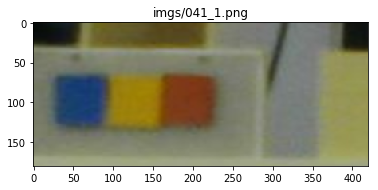

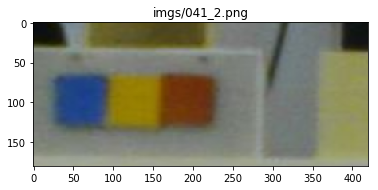

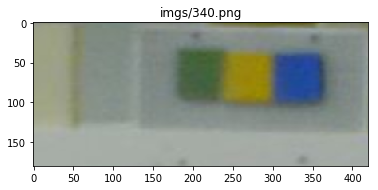

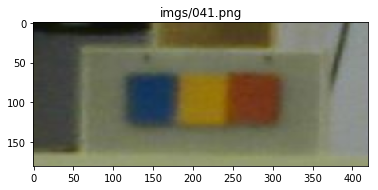

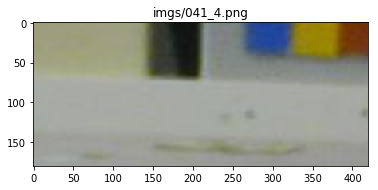

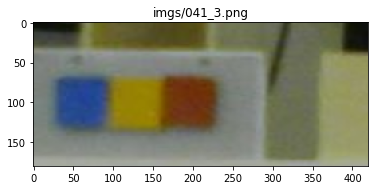

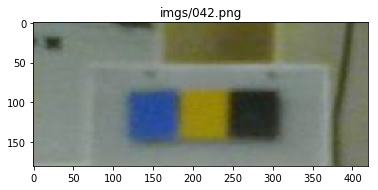

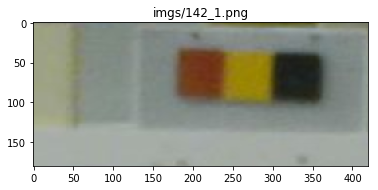

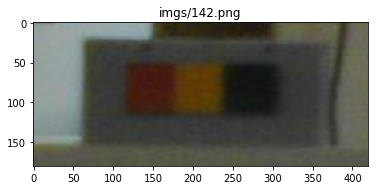

In [17]:
for file, plan in zip(files, plans):
    img_ = cv2.imread(file) 
    img_ = cv2.warpPerspective(img_, M, (w_border, h_border))

    plt.imshow(cv2.cvtColor(img_, cv2.COLOR_RGB2BGR))
    plt.title(file)
    plt.show()   

# Test on many images

In [ ]:
import sys
sys.path.insert(0, r"/home/mikhail/catkin_ws/src/ros-eurobot-2018/eurobot_camera/src/scripts/")
from PlanRecognition 

In [20]:
files = glob.glob("imgs/*.png")
plans = [[int(x_) for x_ in x[5:8]] for x in files]
n_files = len(files)
n_errors = 0
for file, plan in zip(files, plans):
    img_ = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    found_plan = find_colors(img_, M, h_border, w_border)[0] 
    print(found_plan, plan, file)
    if found_plan != plan:
        print(False)
        n_errors += 1
print("Errors: %d from %d" % (n_errors, n_files))

[2, 4, 1] [0, 4, 1] imgs/041_1.png
False
[2, 4, 1] [0, 4, 1] imgs/041_2.png
False
[3, 4, 0] [3, 4, 0] imgs/340.png
[0, 4, 1] [0, 4, 1] imgs/041.png
[0, 4, 1] [0, 4, 1] imgs/041_4.png
[0, 4, 1] [0, 4, 1] imgs/041_3.png
[0, 2, 4] [0, 4, 2] imgs/042.png
False
[1, 4, 2] [1, 4, 2] imgs/142_1.png
[1, 4, 2] [1, 4, 2] imgs/142.png
Errors 3 from 9


In [21]:
%%time
found_plan = find_colors(cv2.cvtColor(cv2.imread("imgs/432.png"), cv2.COLOR_BGR2RGB), M, h_border, w_border)[0]

error: /io/opencv/modules/imgproc/src/color.cpp:11079: error: (-215) scn == 3 || scn == 4 in function cvtColor


## Color metric

In [85]:
diff_colors = np.random.randint(0, 256, (200, 3), dtype=np.uint8)

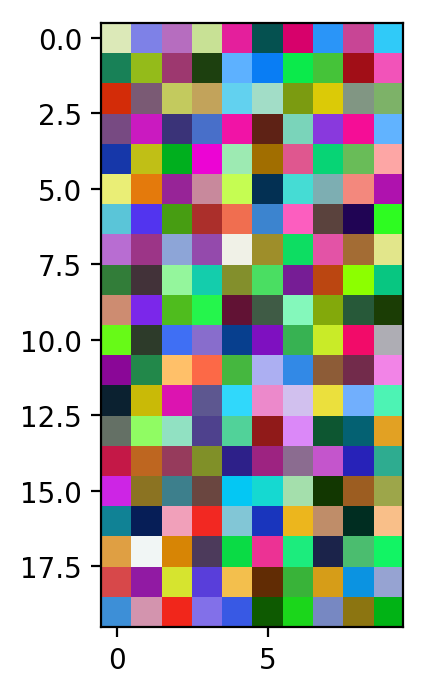

In [86]:
diff_colors_img = diff_colors.reshape(diff_colors.shape[0] // 10, 10, 3)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(diff_colors_img)

In [279]:
colors_dist_ecmc = np.zeros((diff_colors.shape[0], COLORS.shape[0]))
for i in range(COLORS.shape[0]):
    colors_dist_ecmc[:, i] =\
    np.apply_along_axis(color_distance, 1, diff_colors, COLORS[i])

In [280]:
def make_distance_img(colors_dist):
    to_colors = np.argmax(colors_dist, axis=1)
    diff_colors_1 = [(x_, y_, z_) for x_, y_, z_ in zip(diff_colors, 
                     np.argmin(colors_dist, axis=1), np.min(colors_dist, axis=1))]
    imgs = [None] * COLORS.shape[0]
    for i in range(COLORS.shape[0]):
        cols = [(x_[0], x_[2]) for x_ in diff_colors_1 if x_[1] == i]
        cols = sorted(cols, key = lambda x_: x_[1])
        cols = [x_[0] for x_ in cols]
        n = len(cols) + 1
        imgs[i] = np.array([COLORS[i]] + cols + ((10 - n % 10) % 10) * [[255, 255, 255]], 
                           dtype=np.uint8)
        imgs[i] = imgs[i].reshape(imgs[i].shape[0] // 10, 10, 3)
    return np.concatenate(imgs, axis=0)

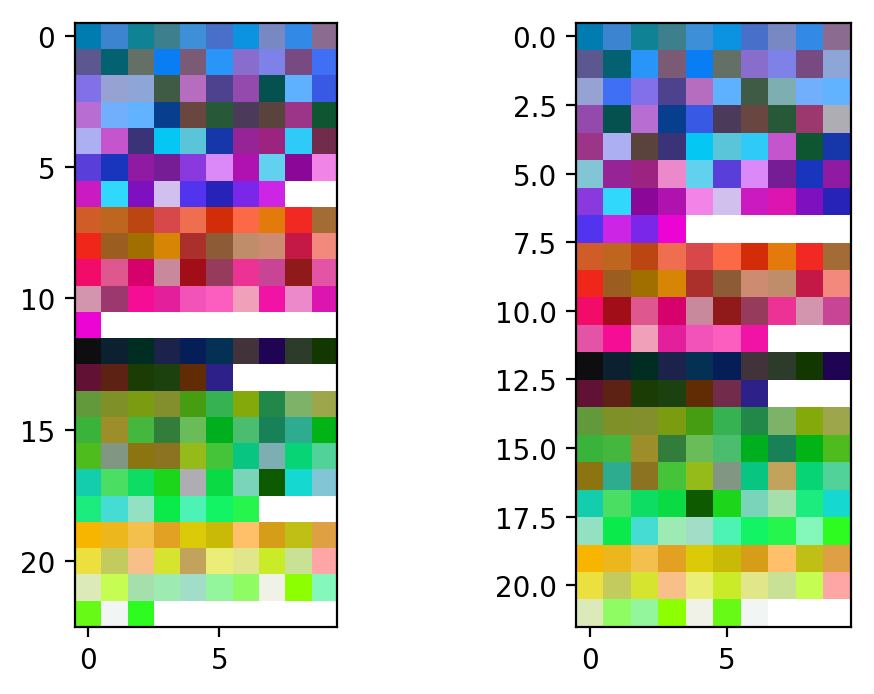

In [288]:
fig, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(make_distance_img(colors_dist_lab2))
ax[1].imshow(make_distance_img(colors_dist_lab))